In [ ]:
import numpy as np
from google.colab import drive
drive.mount('/drive/')

Drive already mounted at /drive/; to attempt to forcibly remount, call drive.mount("/drive/", force_remount=True).


In [ ]:
grey = np.load("/drive/My Drive/ML Data/UTKFaceData/Grey_Preprocessed.npy")
print(grey.shape, grey.dtype)

(23708, 100, 100) uint8


In [ ]:
Y = np.load("/drive/My Drive/ML Data/Age.npy")

print(Y.shape)

(23708, 1)


In [ ]:
Y = Y.astype(np.uint8)
y = Y.ravel()

In [ ]:
Y_final = []
for age in y:
  if age < 15:
    Y_final.append(0)           # Child
  elif age < 25:
    Y_final.append(1)           # Young age
  elif age < 40:
    Y_final.append(2)           # Middle age
  elif age < 70:
    Y_final.append(3)           # Adults
  elif age >= 70:
    Y_final.append(4)           # Old age


In [ ]:
import cv2
import matplotlib.pyplot as plt

# Building Gabor Filters for coloured images.

def build_filters():
   filters = []
   ksize = 31
   for theta in np.arange(0, np.pi, np.pi / 16):
       for lambdat in np.arange(10,11,12):
           for gamma in np.arange(0.5,1,3):
                   kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, lambdat, gamma, 0, ktype=cv2.CV_32F)
                   kern /= 1.5*kern.sum()
                   filters.append(kern)
   return filters

 
def process(img, filters):
    accum = np.zeros_like(img)
    for kern in filters:
        fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
        np.maximum(accum, fimg, accum)
    return accum


The image before Gabor is applied


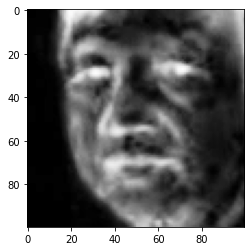

In [ ]:
print("The image before Gabor is applied")
plt.imshow(grey[4867], cmap = 'Greys')
plt.show()

In [ ]:
filters = build_filters()

grey_f1 = []

for i in range(0,23708):
  grey_f1.append(process(grey[i], filters)) 

In [ ]:
greyF1 = np.array(grey_f1,dtype = np.uint8)
del grey_f1

In [ ]:
print("The image after Gabor is applied")

plt.imshow(greyF1[4867], cmap = 'Greys')
plt.show()

In [ ]:
del filters

In [ ]:
print(greyF1.shape)

Now loading the grey dataset.

In [ ]:
for i in range(0,23708):
  
  b1 = cv2.GaussianBlur(grey[i], (1,1), 3)
  b2 = cv2.GaussianBlur(grey[i], (3,3), 3)
  grey[i] = b1 - b2                                       # Applying DoG ( Difference of Guassian )
  

In [ ]:
print(grey.shape)

In [ ]:
del Y

In [ ]:
X_final = np.concatenate((greyF1.reshape(23708,10000), grey.reshape(23708,10000)), axis=1)
print(X_final.shape)

In [ ]:
del grey
del greyF1

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# checking the distribution of labels.
plt.hist(Y_final, bins=15)

Before providing the X_final, the two different datasets would be concatenated and their labels would also be checked.

After the split, we will seperate them again

In [ ]:
y_final = np.array(Y_final)
print(y_final.shape)

In [ ]:
del Y_final

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_final/255,y_final,test_size=0.2, random_state=30)

In [ ]:
np.save("/drive/My Drive/ML Data/jash_ageclassification_X_train.npy", X_train)
np.save("/drive/My Drive/ML Data/jash_ageclassification_y_train.npy", y_train)
np.save("/drive/My Drive/ML Data/jash_ageclassification_X_test.npy", X_test)
np.save("/drive/My Drive/ML Data/jash_ageclassification_y_test.npy", y_test)

In [ ]:
del X_final, y_final

In [ ]:
import numpy as np

X_train = np.load("/drive/My Drive/ML Data/jash_ageclassification_X_train.npy")
y_train = np.load("/drive/My Drive/ML Data/jash_ageclassification_y_train.npy")
X_test = np.load("/drive/My Drive/ML Data/jash_ageclassification_X_test.npy")
y_test = np.load("/drive/My Drive/ML Data/jash_ageclassification_y_test.npy")

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(X_train.dtype, X_test.dtype, y_train.shape, y_test.shape)

(18966, 20000) (4742, 20000) (18966,) (4742,)
float64 float64 (18966,) (4742,)


In [ ]:
X_train = X_train.astype(np.uint8)
X_test = X_test.astype(np.uint8)
y_train = y_train.astype(np.uint8)
y_test = X_test.astype(np.uint8)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(X_train.dtype, X_test.dtype, y_train.shape, y_test.shape)

(18966, 20000) (4742, 20000) (18966,) (4742, 20000)
uint8 uint8 (18966,) (4742, 20000)


In [ ]:

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA( n_components= 3 )
X_train_final = lda.fit_transform(X_train, y_train)
del X_train


In [ ]:

X_test_final = lda.transform(X_test)
del X_test


'\nX_test_final = lda.transform(X_test)\ndel X_test\n'

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(estimator=LogisticRegressionCV())

X_train_final = selector.fit_transform(X_train,y_train)
X_test_final = selector.ransform(X_test)

del X_train
del X_test

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 1000, random_state=0, class_weight='balanced')
clf.fit(X_train , y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
print(y_pred)

In [ ]:
from sklearn.metrics import classification_report as clr
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4']
print(clr(y_test,y_pred, target_names=target_names))

In [ ]:
np.save("/drive/My Drive/ML Data/jash_ageclassification_y_pred.npy", y_pred)
